# Previsão de Valores de Residência na Califórnia

## Objetivo do Projeto
Este projeto tem como objetivo desenvolver modelos de machine learning para prever valores de residências na Califórnia utilizando o dataset California Housing. Vamos comparar diferentes abordagens de pré-processamento e algoritmos de regressão.

## Metodologia
A abordagem será dividida em:
1. Pré-processamento dos dados
2. Teste de diferentes modelos de regressão
3. Avaliação comparativa dos resultados
4. Seleção do melhor modelo

#  **Esse Notebook Foi Projetado Com Uma `Arquitetura Modular` Para Experimentação em Machine Learning**  

## **Construindo um framework profissional** que: 

**Padroniza** a comparação entre algoritmos  
**Reduz** erros humanos em reimplementações  
**Permite** testar mais hipóteses em menos tempo 
**Documenta** cientificamente diferentes métricas do modelo e cada decisão técnica 

Vantagens:
- Simples e rápido para afetuar a troca de modelos 
- GridSearch automático por tipo de modelo
- Benchmarking justo (mesmo pré-processamento) para diferentes modelos e parâmetros
- Reprodutibilidade: Pode executar seu código e ver os mesmos resultados apresentados
- Rastreabilidade: Storytelling completa de evolução do modelo

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.26,37.84,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294118,2.026891,0.260274
3,-122.26,37.85,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.26,37.84,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343675,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 17564 non-null  float64
 1   latitude                  17564 non-null  float64
 2   housing_median_age        17564 non-null  int8   
 3   total_rooms               17564 non-null  int16  
 4   total_bedrooms            17564 non-null  int16  
 5   population                17564 non-null  int16  
 6   households                17564 non-null  int16  
 7   median_income             17564 non-null  float64
 8   median_house_value        17564 non-null  int32  
 9   ocean_proximity           17564 non-null  object 
 10  median_income_cat         17564 non-null  int64  
 11  rooms_per_household       17564 non-null  float64
 12  population_per_household  17564 non-null  float64
 13  bedrooms_per_room         17564 non-null  float64
dtypes: flo

## Pré-processamento com ColumnTransformer

O `ColumnTransformer` do scikit-learn permite aplicar diferentes transformações a diferentes colunas do dataset simultaneamente.

### Transformadores Utilizados:
1. **OrdinalEncoder**: 
   - Converte variáveis categóricas ordinais em valores numéricos mantendo a relação de ordem
   - `categories="auto"` detecção automática da relação de ordem da feature
   - Aplicado em: `median_inccome_cat`
     
2. **OneHotEncoder**:
   - Cria variáveis dummy para variáveis categóricas nominais
   - `drop="first"` remove uma coluna para evitar multicolinearidade
   - Aplicado em: `ocean_proximity`

3. **remainder="passthrough"**:
   - Mantém todas as colunas não especificadas sem transformação

In [4]:
coluna_target = ["median_house_value"]

coluna_one_hot_encoder = ["ocean_proximity"]

coluna_ordinal_encoder = ["median_income_cat"]

In [5]:
preprocessamento = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        ("one_hot", OneHotEncoder(drop="first"), coluna_one_hot_encoder),
    ],
    remainder="passthrough",
)

In [6]:
X = df.drop(columns=coluna_target)
y = df[coluna_target]

In [7]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.23,37.88,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.26,37.84,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294118,2.026891,0.260274
3,-122.26,37.85,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.26,37.84,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343675,2.362768,0.203216


In [8]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


## Comparação de Modelos de Regressão

Testando três abordagens diferentes:

### 1. DummyRegressor
- **Função**: Serve como linha de base para comparação
- **Estratégia**: Prevê a média dos valores de treino
- **Pré-processador**: Nenhum
- **Transformação do target**: Nenhuma

### 2. LinearRegression Padrão
- **Algoritmo**: Regressão Linear tradicional
- **Pré-processador**: ColumnTransformer configurado
- **Transformação do target**: Nenhuma

### 3. LinearRegression com Transformação do Target
- **Algoritmo**: Regressão Linear
- **Pré-processador**: ColumnTransformer configurado
- **Transformação do target**: PowerTransformer
   - Aplica transformação de potência para tornar a distribuição mais normal
   - Útil quando o target tem distribuição assimétrica

In [9]:
target_transformer = PowerTransformer()

regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    "LinearRegression": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_target": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": target_transformer,
    },
}

In [10]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.006994,0.009001,-0.000081,-77516.042766,-96239.705692,0.015995
1,DummyRegressor,0.003,0.004999,-0.000146,-75787.787194,-95217.629397,0.007999
2,DummyRegressor,0.006005,0.004001,-0.001737,-76753.598961,-96253.253947,0.010006
3,DummyRegressor,0.003999,0.004999,-0.000101,-76837.804811,-95983.885799,0.008998
4,DummyRegressor,0.004004,0.003998,-0.000114,-76617.245449,-96182.764729,0.008002
5,LinearRegression,0.139002,0.019001,0.682162,-39855.691222,-54254.958862,0.158004
6,LinearRegression,0.027001,0.012002,0.66999,-40272.5658,-54695.230987,0.039003
7,LinearRegression,0.027001,0.013002,0.649247,-42178.059695,-56955.987903,0.040002
8,LinearRegression,0.023002,0.011998,0.669873,-40806.492334,-55146.319086,0.035001
9,LinearRegression,0.027999,0.014002,0.669023,-40788.497206,-55331.350878,0.042001


In [11]:
df_resultados.groupby("model").mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.004801,0.0054,-0.000436,-76702.495836,-95975.447913,0.0102
LinearRegression,0.048801,0.014001,0.668059,-40780.261251,-55276.769543,0.062802
LinearRegression_target,0.061001,0.0134,0.671185,-38909.259607,-55011.704645,0.074401


## Interpretação dos Resultados

### Métricas presentes no df_resultados:
- **fit_time**: Tempo de treinamento do modelo
- **score_time**: Tempo para fazer previsões
- **test_r2**: Coeficiente de determinação (R²) no conjunto de teste
- **test_neg_mean_absolute_error**: MAE negativo (por convenção do scikit-learn)
- **test_neg_root_mean_squared_error**: RMSE negativo (por convenção do scikit-learn)
- **time_seconds**: Tempo total


### Conclusões Iniciais:
1. A transformação do target trouxe uma pequena melhoria no R² (0.668 -> 0.671)
2. A transformação de target reduziu o MAE em ~5% (40,780 → 38,909)
3. O tempo de execução permaneceu praticamente igual considerando a média 
4. Ambos os modelos lineares superam significativamente a baseline o que mostra interessante a elaboração de modelos de machine learning

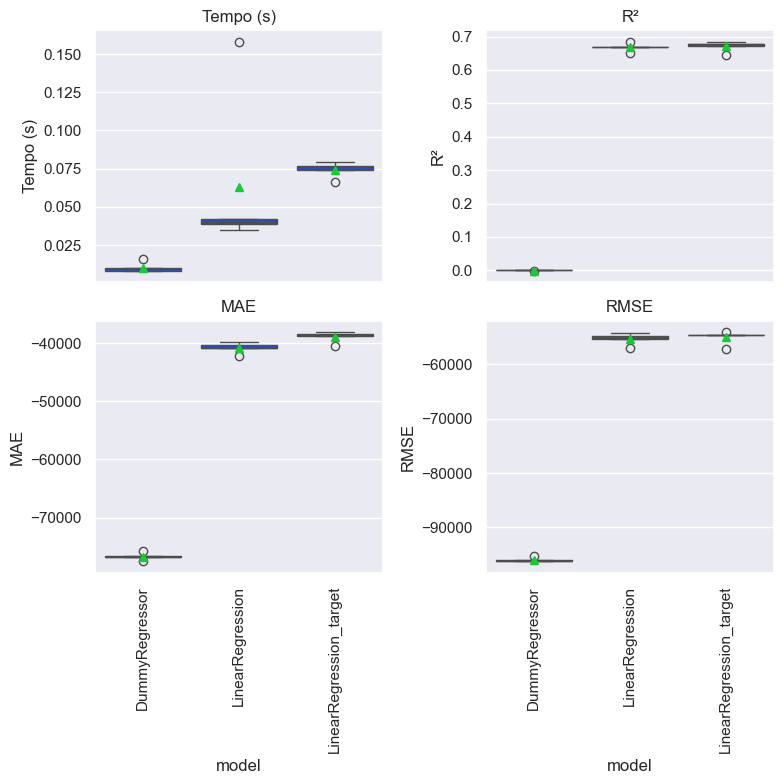

In [12]:
plot_comparar_metricas_modelos(df_resultados)

## Busca de Melhores Parâmetros com GridSearch

Nesta etapa, utilizamos o `GridSearchCV` para encontrar a melhor transformação para nossa variável target.

### Configuração do GridSearch:
```python
param_grid = {
    "transformer": [
        None,  # Nenhuma transformação
        PowerTransformer(),  # Transformação de potência
        QuantileTransformer(output_distribution="normal")  # Transformação para distribuição normal
    ]
}

In [13]:
param_grid = {
    "transformer": [None, PowerTransformer(), QuantileTransformer(output_distribution="normal")]
}

In [14]:
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(),
    preprocessor=preprocessamento,
    target_transformer=target_transformer,
    param_grid=param_grid,
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity'])])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=PowerTransformer()),
             n_jobs=-1,
             param_grid={'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [15]:
grid_search.fit(X, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity'])])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=PowerTransformer()),
             n_jobs=-1,
             param_grid={'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)


## 2. Atualização dos Regressores Testados

## Configuração dos Modelos Atualizados

Agora com 4 variações de modelos:

1. **DummyRegressor**: Continua como baseline
2. **LinearRegression padrão**: Sem transformação no target
3. **LinearRegression com PowerTransformer**: Versão anterior otimizada
4. **LinearRegression com QuantileTransformer**: Nova versão otimizada pelo GridSearch

### Detalhes da Melhor Configuração:
- **Pré-processador**: O mesmo ColumnTransformer da etapa anterior
- **Regressor**: LinearRegression padrão
- **Transformação do target**: QuantileTransformer (melhor resultado do GridSearch)

In [16]:
grid_search.best_params_

{'transformer': QuantileTransformer(output_distribution='normal')}

In [17]:
grid_search.best_score_

np.float64(-54431.34494296915)

## Análise dos Coeficientes do Modelo Linear

### Objetivo da Análise:
Entender como cada feature contribui para as previsões do modelo através dos coeficientes da regressão linear.


In [18]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out(),
)

coefs

,coeficiente
one_hot__ocean_proximity_INLAND,-0.456978
remainder__longitude,-0.295588
remainder__latitude,-0.289101
remainder__population_per_household,-0.281437
one_hot__ocean_proximity_NEAR BAY,-0.202286
one_hot__ocean_proximity_NEAR OCEAN,-0.060758
remainder__total_bedrooms,-0.000223
remainder__total_rooms,-0.000061
remainder__population,-0.000034
remainder__households,0.000853


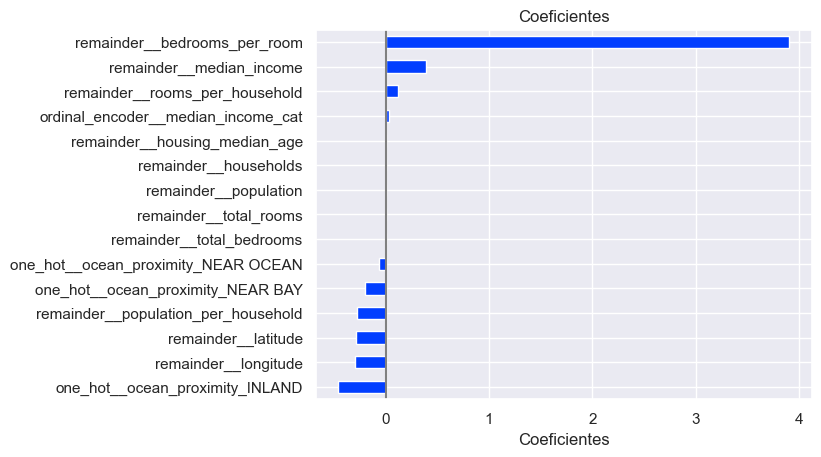

In [23]:
# Criando um gráfico para visualizar as features mais relevantes para o modelo 
plot_coeficientes(coefs)

In [20]:
regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    "LinearRegression": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_target_power": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": target_transformer,
    },
    "LinearRegression_target_quantile": {
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    },
}


resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.007004,0.007003,-0.000081,-77516.042766,-96239.705692,0.014007
1,DummyRegressor,0.003997,0.006,-0.000146,-75787.787194,-95217.629397,0.009997
2,DummyRegressor,0.003,0.005,-0.001737,-76753.598961,-96253.253947,0.007999
3,DummyRegressor,0.004001,0.004997,-0.000101,-76837.804811,-95983.885799,0.008997
4,DummyRegressor,0.003032,0.006019,-0.000114,-76617.245449,-96182.764729,0.009052
5,LinearRegression,0.023005,0.016993,0.682162,-39855.691222,-54254.958862,0.039999
6,LinearRegression,0.030999,0.016003,0.66999,-40272.5658,-54695.230987,0.047002
7,LinearRegression,0.02501,0.011991,0.649247,-42178.059695,-56955.987903,0.037001
8,LinearRegression,0.034998,0.015002,0.669873,-40806.492334,-55146.319086,0.05
9,LinearRegression,0.025999,0.017001,0.669023,-40788.497206,-55331.350878,0.043


In [21]:
df_resultados.groupby("model").mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.004207,0.005804,-0.000436,-76702.495836,-95975.447913,0.010011
LinearRegression,0.028002,0.015398,0.668059,-40780.261251,-55276.769543,0.0434
LinearRegression_target_power,0.056801,0.015198,0.671185,-38909.259607,-55011.704645,0.071999
LinearRegression_target_quantile,0.038001,0.012999,0.678086,-38679.810329,-54431.641253,0.051


## Comparação dos Resultados usando o GridSearch

### Conclusões:
1. O **QuantileTransformer** obteve o melhor desempenho geral:
   - Melhor R² (0.6781 vs 0.6712 anterior)
   - Menor MAE (38,680 vs 38,909 anterior)
   - Menor RMSE (54,432 vs 55,012 anterior)

2. O tempo de execução do modelo otimizado (0.051s) ficou entre:
   - Versão sem transformação (0.043s)
   - Versão com PowerTransformer (0.072s)


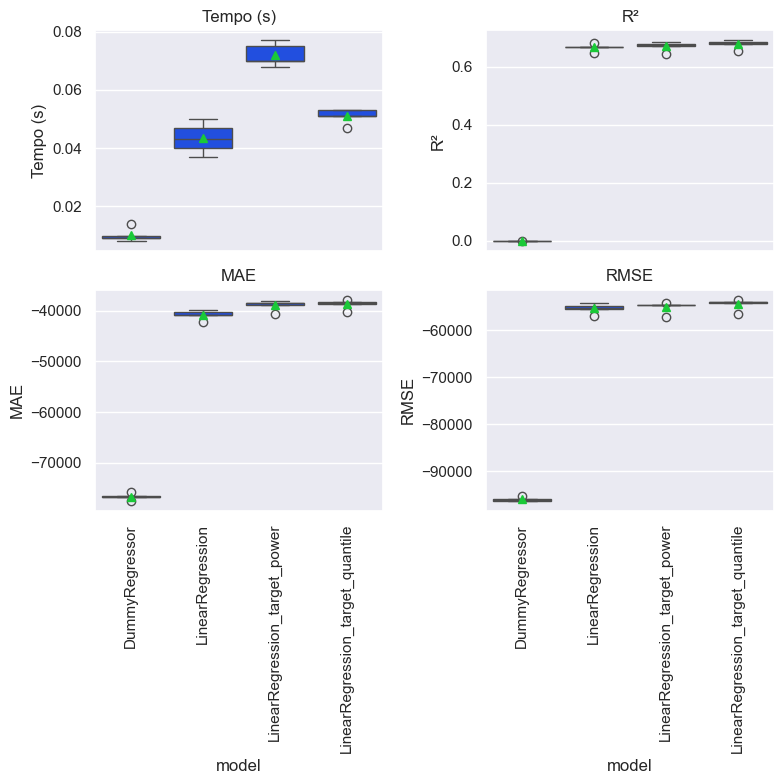

In [22]:
plot_comparar_metricas_modelos(df_resultados)

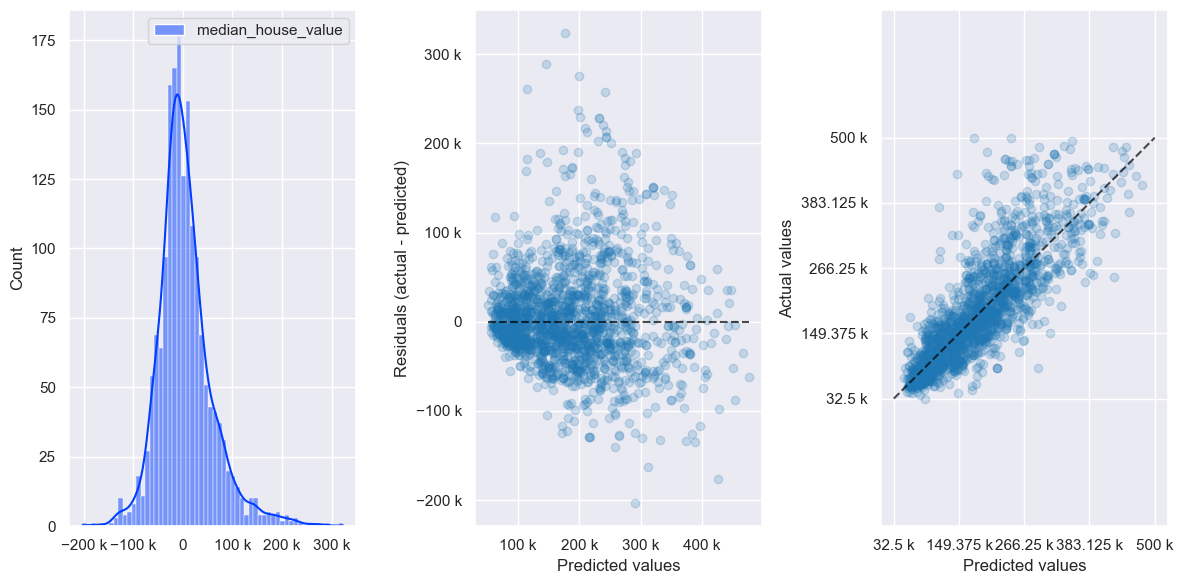

In [24]:
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.1, eng_formatter=True)